<a href="https://colab.research.google.com/github/LueMar-R/P29_langage_signes_alphabet/blob/main/02_classification_signes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconnaissance des signes de l'alphabet LSF

<hr>

- <a href='#1'>Prévisualisation des données</a>
- <a href='#2'>Création des datasets d'apprentissage et de test</a>
- <a href='#3'>Extraction des mains dans les photographies du dataset</a>
- <a href='#4'>Entrainement du modèle de reconnaissance des signes sur le nouveau dataset</a>
- <a href='#5'>Résultats</a> 

<hr>

In [1]:
#préparation des imports (bibliothèques et librairies nécéssaires à l'éxécution du code)
import os
import sys
import numpy as np
import time
import cv2
import pickle

from glob import glob

from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.layers import Conv2D, experimental, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical

### <a id='1'>Prévisualisation des données</a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/P29_sign_langage/notebooks/'
%ls

/content/drive/MyDrive/P29_sign_langage/notebooks
03_reconnaissance_signes_video.ipynb  modelX2/
capture_webcam.ipynb                  NUL_video_mediapipe_mlp.ipynb
classification_27.ipynb               reconnaissance_video.ipynb
classification.ipynb                  Ronan.ipynb
datalearning.zip                      X_test.npy
dt/                                   X_train.npy
fulldata/                             y_test.npy
fulldata.zip                          y_train.npy
modelX/


In [4]:
#!unzip fulldata.zip

Archive:  fulldata.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of fulldata.zip or
        fulldata.zip.zip, and cannot find fulldata.zip.ZIP, period.


In [4]:
#nous accédons aux données depuis le dossier dans lequel elles sont stockées
tmp = os.listdir("./fulldata") 

print("La liste 'tmp' contient les noms de chacun des dossiers. Les voici : ")
print(" ->", ", ".join(tmp))

#On prépare les labels en les récupérant à partir des noms de dossier.
LABELS ={} 
for clas, letter in enumerate(tmp): # on itère sur la liste tmp pour récupérer ces labels.
    LABELS[clas]=letter

NUM_CLASS = len(tmp)

print("\nIl y a donc", NUM_CLASS, "classes, que nous encoderons ainsi dans l'ordre des dossiers :")
print(LABELS)

La liste 'tmp' contient les noms de chacun des dossiers. Les voici : 
 -> l, m, n, o, p, q, r, s, t, v, u, w, x, y, z, _, a, b, c, d, f, e, g, h, i, j, k

Il y a donc 27 classes, que nous encoderons ainsi dans l'ordre des dossiers :
{0: 'l', 1: 'm', 2: 'n', 3: 'o', 4: 'p', 5: 'q', 6: 'r', 7: 's', 8: 't', 9: 'v', 10: 'u', 11: 'w', 12: 'x', 13: 'y', 14: 'z', 15: '_', 16: 'a', 17: 'b', 18: 'c', 19: 'd', 20: 'f', 21: 'e', 22: 'g', 23: 'h', 24: 'i', 25: 'j', 26: 'k'}


In [12]:
#création du dataset global
dataset = []
for i in tmp:
    chemin = "./fulldata/"+i
    img = glob(f"{chemin}/*.png")
    img = [os.path.abspath(x) for x in img]
    dataset.append(img)

# Affichage du nombre d'images par catégorie:
print("Nombre d'images de chaque classe dans le dataset :")
print([(LABELS[i], len(dataset[i])) for i in range(len(dataset))])

Nombre d'images de chaque classe dans le dataset :
[('l', 80), ('m', 55), ('n', 63), ('o', 76), ('p', 76), ('q', 79), ('r', 92), ('s', 79), ('t', 77), ('v', 103), ('u', 77), ('w', 66), ('x', 65), ('y', 75), ('z', 88), ('_', 98), ('a', 90), ('b', 72), ('c', 73), ('d', 93), ('f', 43), ('e', 40), ('g', 67), ('h', 68), ('i', 116), ('j', 71), ('k', 80)]


### <a id='2'>Création des datasets d'apprentissage et de test</a>

In [15]:
#Création des la liste des targets
paths=[]
y=[]

for i in range(len(dataset)):
    for j in range(len(dataset[i])):
        paths.append(dataset[i][j])
        y.append(i)

In [16]:
#Création des la liste des Features
X=[]
for p in paths:
    X.append(cv2.cvtColor(cv2.imread(p, 3), cv2.COLOR_BGR2RGB ))

Il y a 2062 images de (480, 640, 3) pixels dans le dataset. 
Voici par exemple l'image n°42 :


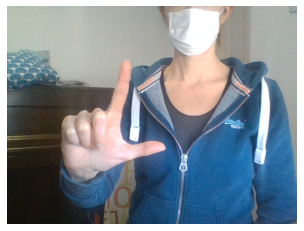

In [32]:
plt.imshow(X[42])
plt.axis("off")
print(f"Il y a {len(X)} images de {X[42].shape} pixels dans le dataset.\
 \nVoici par exemple l'image n°42 :")

### Extraction de l'image de la main dans la photo

#### Détection de la main avec Médiapipe

In [24]:
!pip install mediapipe

     |████████████████████████████████| 47.4MB 63kB/s 


In [27]:
def find_rectangle_coord(hand_landmarks, image):
    image_height, image_width, _ = image.shape
    keypoints = []
    for data_point in hand_landmarks.landmark:
        keypoints.append({
                            'X': data_point.x*image_width,
                            'Y': data_point.y*image_height,                            
                            })
    
    X_min = image_width
    X_max = 0
    Y_min = image_height
    Y_max = 0

    #print(keypoints[0]['X'])
    for x in range(len(keypoints)):
        if (keypoints[x]['X']) < X_min:
            X_min = (keypoints[x]['X'])
        if (keypoints[x]['X']) > X_max:
            X_max = (keypoints[x]['X'])

    for y in range(len(keypoints)):
        if (keypoints[y]['Y']) < Y_min:
            Y_min = (keypoints[y]['Y'])
        if (keypoints[y]['Y']) > Y_max:
            Y_max = (keypoints[y]['Y'])

    startX = int(X_min -0.05* image_width)
    startY = int(Y_min -0.05* image_height)
    endX = int(X_max +0.05* image_width)
    endY = int(Y_max +0.05* image_height)
    #rect = cv2.rectangle(image, (startX, startY), (endX, endY), (155, 255, 0), 2)

    return startX, startY, endX, endY

In [28]:
import cv2
import mediapipe as mp

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

newX=[]
# For static images:
with mp_hands.Hands(static_image_mode=True,
                    max_num_hands=2,
                    min_detection_confidence=0.5) as hands:
    for image in X:
        
        image.flags.writeable = False
        results = hands.process(image)
        image.flags.writeable = True


        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                ## récupération des coordonnées des 4 coins du rectangle grace à la fonction find_rectangle.
                x1, y1, x2, y2 = find_rectangle_coord(hand_landmarks, image)
                ## extraction de l'image de la main + rognage, redimmensionnement, standartisation.
                try :
                  cropped = image[y1:y2, x1:x2] 
                  localized = cv2.resize(cropped,(60,60)).astype('float') / 255
                except: pass

        newX.append(localized)



In [29]:
nexW = np.asarray(newX)

In [30]:
LABELS[y[42]]

'l'

Voici par exemple la nouvelle image n°42 :


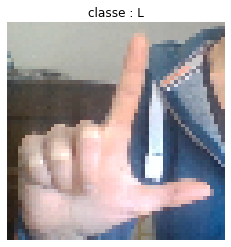

In [31]:
plt.imshow(newX[42])
plt.axis("off")
plt.title(f"classe : {LABELS[y[42]].upper()}")
print(f"Voici par exemple la nouvelle image n°42 :")

### <a id='3'>Préparation des données</a>

#### Séparation des données de test et d'entrainement

In [33]:
 from sklearn.model_selection import train_test_split

 X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.2, random_state=42)

#### Mélange des données

In [34]:
# pour l'entraînement
index = np.random.permutation([i for i in range(len(y_train))])

X_train = np.asarray(X_train)[index]
y_train = np.asarray(y_train)[index]
print(X_train.shape)
print(y_train.shape)

(1649, 60, 60, 3)
(1649,)


In [35]:
# pour les tests
index2 = np.random.permutation([i for i in range(len(y_test))])

X_test = np.asarray(X_test)[index2]
y_test = np.asarray(y_test)[index2]
print(X_test.shape)
print(y_test.shape)

(413, 60, 60, 3)
(413,)


Visualisons maintenant quelques-une de ces images, par exemple les 15 premières, en affichant le label, afin de vérifier notre dataset avant de commencer l'entraînement.

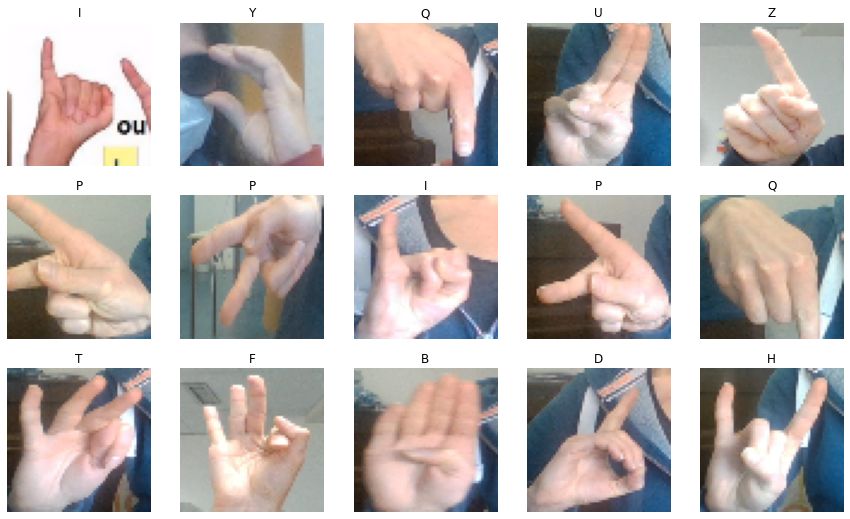

In [36]:
# visualisation
plt.figure(figsize=(15,9))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(X_train[i])
    plt.title(LABELS[y_train[i]].upper())
    plt.axis('off')
plt.show()

##### Sauvegarde des données

In [37]:
with open('X_train.npy', 'wb') as f:
    np.save(f, X_train)
with open('X_test.npy', 'wb') as f:
    np.save(f, X_test)

with open('y_train.npy', 'wb') as f:
    np.save(f, y_train)
with open('y_test.npy', 'wb') as f:
    np.save(f, y_test)

### <a id='4'>Reconnaissance des signes avec un CNN</a>

##### Prétraitement en vue de l'entrainement avec un CNN Séquentiel 

In [5]:
with open('X_train.npy', 'rb') as f:
    X_train = np.load(f)
with open('X_test.npy', 'rb') as f:
    X_test = np.load(f)
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
with open('y_test.npy', 'rb') as f:
    y_test = np.load(f)

In [6]:
# redimensionnement des features

""" les données sont déjà standardisées : """
print("X min :", np.min(X_train), ", X max :", np.max(X_train))
""" et déjà dimensionnées dnas un format admissible par un CNN :"""
print("X shape:", X_train.shape)


X min : 0.0 , X max : 1.0
X shape: (1649, 60, 60, 3)


In [7]:
# encodage (catégorisation) des targets
y_test.reshape(len(y_test),1)
y_train.reshape(len(y_train),1)
Y_train = to_categorical(y_train, num_classes=NUM_CLASS).astype(int)
Y_test = to_categorical(y_test, num_classes=NUM_CLASS).astype(int)

In [8]:
# vérificationpour un élément au hasard du set d'entrainement
print(f"classe encodée : {Y_train[42]} \nclasse décodée : {y_train[42]} \nlabel : {LABELS[y_train[42]].upper()}") 

classe encodée : [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
classe décodée : 1 
label : M


###### Création du modèle séquentiel

In [9]:
modelX = models.Sequential()

modelX.add(Conv2D(64, 7, padding="same", activation='relu', input_shape=(60,60,3)))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Conv2D(64, 3, padding="same", activation='relu'))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Conv2D(128, 3, padding="same", activation='relu'))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Flatten())
modelX.add(Dense(64, activation="relu"))
modelX.add(Dropout(0.25))
modelX.add(Dense(32, activation="relu"))
modelX.add(Dropout(0.25))
modelX.add(Dense(NUM_CLASS, activation='softmax'))

In [10]:
# premier entraînement avec Adamax
modelX.compile(optimizer=optimizers.Adamax(learning_rate=0.0001, beta_1=0.9, beta_2=0.97), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = modelX.fit(X_train, Y_train, epochs=160, batch_size=8, validation_split=0.2)

Epoch 1/160
165/165 [==============================] - 9s 9ms/step - loss: 3.3207 - accuracy: 0.0346 - val_loss: 3.2925 - val_accuracy: 0.0636
Epoch 2/160
165/165 [==============================] - 1s 6ms/step - loss: 3.2945 - accuracy: 0.0380 - val_loss: 3.2920 - val_accuracy: 0.0485
Epoch 3/160
165/165 [==============================] - 1s 6ms/step - loss: 3.2824 - accuracy: 0.0437 - val_loss: 3.2902 - val_accuracy: 0.0970
Epoch 4/160
165/165 [==============================] - 1s 6ms/step - loss: 3.2773 - accuracy: 0.0483 - val_loss: 3.2842 - val_accuracy: 0.1091
Epoch 5/160
165/165 [==============================] - 1s 6ms/step - loss: 3.2714 - accuracy: 0.0760 - val_loss: 3.2785 - val_accuracy: 0.0848
Epoch 6/160
165/165 [==============================] - 1s 6ms/step - loss: 3.2330 - accuracy: 0.0727 - val_loss: 3.2786 - val_accuracy: 0.0788
Epoch 7/160
165/165 [==============================] - 1s 6ms/step - loss: 3.2588 - accuracy: 0.0680 - val_loss: 3.2738 - val_accuracy: 0.0848

In [15]:
# premier entraînement avec Adamax
modelX.compile(optimizer=optimizers.Adamax(learning_rate=0.00001, beta_1=0.97, beta_2=0.98), loss='categorical_crossentropy', metrics=['accuracy'])
history = modelX.fit(X_train, Y_train, epochs=20, batch_size=5, validation_split=0.2)

Epoch 1/20
264/264 [==============================] - 2s 6ms/step - loss: 0.7132 - accuracy: 0.7869 - val_loss: 0.6633 - val_accuracy: 0.8273
Epoch 2/20
264/264 [==============================] - 1s 5ms/step - loss: 0.7338 - accuracy: 0.7882 - val_loss: 0.6663 - val_accuracy: 0.8242
Epoch 3/20
264/264 [==============================] - 1s 5ms/step - loss: 0.7757 - accuracy: 0.7597 - val_loss: 0.6630 - val_accuracy: 0.8273
Epoch 4/20
264/264 [==============================] - 1s 5ms/step - loss: 0.7530 - accuracy: 0.7707 - val_loss: 0.6624 - val_accuracy: 0.8273
Epoch 5/20
264/264 [==============================] - 2s 6ms/step - loss: 0.7349 - accuracy: 0.7749 - val_loss: 0.6609 - val_accuracy: 0.8303
Epoch 6/20
264/264 [==============================] - 1s 5ms/step - loss: 0.8010 - accuracy: 0.7580 - val_loss: 0.6603 - val_accuracy: 0.8303
Epoch 7/20
264/264 [==============================] - 1s 6ms/step - loss: 0.7458 - accuracy: 0.7741 - val_loss: 0.6638 - val_accuracy: 0.8303
Epoch 

In [16]:
modelX.save('modelX')

INFO:tensorflow:Assets written to: modelX/assets


##### Validation sur la base de données de test

In [50]:
modelX = models.load_model('modelX')

In [17]:
Y_pred = modelX.predict(X_test)

In [18]:
y_pred=[]
for y in Y_pred:
    y_pred.append(np.argmax(y))

In [19]:
cf_matrix = confusion_matrix(y_test, y_pred)

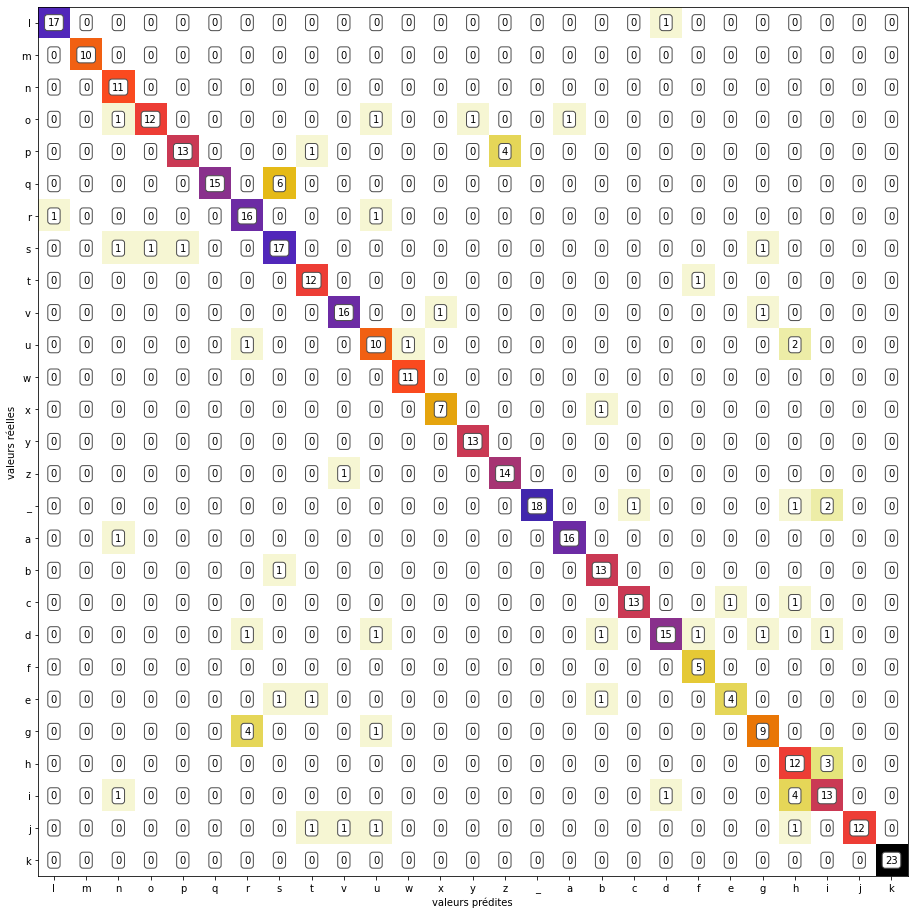

In [20]:
plt.figure(figsize=(16,16))
plt.imshow(cf_matrix, cmap="CMRmap_r")
for (i, j), z in np.ndenumerate(cf_matrix):
    plt.text(j, i, z, ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xlabel("valeurs prédites")
plt.xticks(ticks =[i for i in range(NUM_CLASS)], labels=[LABELS[i] for i in range(NUM_CLASS)])
plt.ylabel("valeurs réelles")
plt.yticks(ticks =[i for i in range(NUM_CLASS)], labels=[LABELS[i] for i in range(NUM_CLASS)])
plt.show()

### <a id='4'>Reconnaissance des signes avec un classificateur MLP</a>

##### Prétraitement en vue de l'entrainement avec un classificateur MLP


In [28]:
### chargement des données
with open('X_train.npy', 'rb') as f:
    X_train = np.load(f)
with open('X_test.npy', 'rb') as f:
    X_test = np.load(f)
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
with open('y_test.npy', 'rb') as f:
    y_test = np.load(f)

In [29]:
# un MLP prend en entrée une série de vecteurs lignes
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3])
print(X_train.shape)

(1649, 60, 60, 3)
(1649, 10800)


###### Création et entrainement du modèle MPL

In [31]:
# utilisation d'un réseau de neurones à deux couches cachées de 200 et 60 neurones :
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(200,60))

In [32]:
mlp.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200, 60), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

##### Validation sur la base de données de test

In [33]:
y_pred = mlp.predict(X_test)

In [34]:
cf_matrix = confusion_matrix(y_test, y_pred)

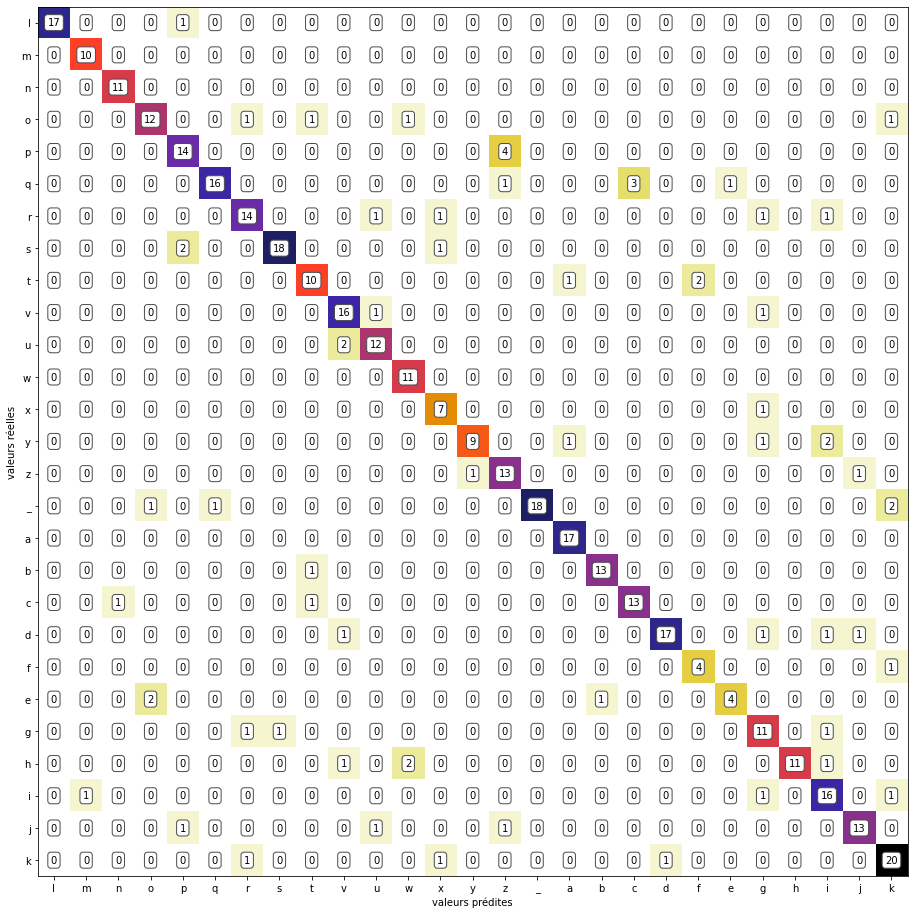

Accuracy : 0.8401937046004843


In [37]:
plt.figure(figsize=(16,16))
plt.imshow(cf_matrix, cmap="CMRmap_r")
for (i, j), z in np.ndenumerate(cf_matrix):
    plt.text(j, i, z, ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xlabel("valeurs prédites")
plt.xticks(ticks =[i for i in range(NUM_CLASS)], labels=[LABELS[i] for i in range(NUM_CLASS)])
plt.ylabel("valeurs réelles")
plt.yticks(ticks =[i for i in range(NUM_CLASS)], labels=[LABELS[i] for i in range(NUM_CLASS)])
plt.show()
mlp_score = accuracy_score(y_test, y_pred)
print("Accuracy :", mlp_score)

In [ ]:
pickle.dump(mlp, open("ModelMLP.sav", 'wb'))

### Bilan

Nos deux modèles de classification semblent bien fonctionner. Ceci est à mettre en perspecive avec le faible nombre et la faible diversité des données. Cela ne signifie donc pas que la reconnaissance video, dans des environnements différents de ceux dans lequels ont été prises les photos, sera parfaite.

Le modèle MLP obtient un score final de 84.02%, contre 82.42% pour le CNN. <br>
Il est également plus léger et plus rapide à exécuter, il semble donc être préféreble de privilégier celui-ci pour la phase finale de lecture d'un flux vidéo. Nous pourront cependant tester les deux.